In [4]:
import numpy as np
import background as bac
import matplotlib.pyplot as plt
import matplotlib as mpl

import emcee
import corner

from pathlib import Path
import os

%matplotlib inline
plt.rcParams['figure.figsize'] = (12,5)
cwd=os.getcwd()

In [3]:
path_hu = cwd + '/data/hubel.dat'
hub_file = Path(path_hu)
if hub_file.is_file():
    hub = np.genfromtxt(path_hu)
    z_obs = hub[:,0]
    H_obs = hub[:,1]
    dH_obs = hub[:,2]
    print("Hubble data are loaded")
    
else:
    print("Hubble files do not exist")
    sys.exit(0) 

Hubble data are loaded


# Functions needed for emcee

In [6]:
def lnlike(theta, x_obs, y_obs, yerr):
    H0, om = theta
    #if om < 0 :
    #    return -np.inf
    y_th = bac.Hubble(x_obs,[H0,om])
    x = ( y_th - y_obs)/yerr
    LnLike = -0.5*np.dot(x,x)
    return LnLike  


def lnprior(theta):
    H0 , om = theta
    if om > 0 and om < 1.:
        return 0.0
    else:
        return -np.inf 
        
def lnprob(theta, x_obs, y_obs, yerr):
    lp = lnprior(theta)
    if lp is -np.inf : #check if lp is infinite:
        return -np.inf
    return lp + lnlike(theta, x_obs, y_obs, yerr)

In [7]:
initial = np.array([65.0, .2])
ndim = len(initial)
nwalkers = 50
niter_burn = 80
niter = 300
p0 = [np.array(initial) + 1e-2 * np.random.randn(ndim) for i in range(nwalkers)]

#print("initial p0",p0)

obs_data = (z_obs,H_obs,dH_obs)


print("\n")
print("Running burn-in...\n")
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=obs_data)
p0, _, _ = sampler.run_mcmc(p0,niter_burn,progress=True)
sampler.reset()

print("\n")
print("Running production...\n")
pos, prob, state = sampler.run_mcmc(p0, niter,progress=True)   

 36%|███▋      | 29/80 [00:00<00:00, 289.79it/s]

Running burn-in...

  8%|▊         | 25/300 [00:00<00:01, 246.87it/s]

Running production...

100%|██████████| 300/300 [00:00<00:00, 397.05it/s]


Chain shape is  (300, 50, 2)
number of samples = 15000
H0= 71.97873249489668
Omega_m= 0.237840147047095
sigma_H0= 1.064035783584632
sigma_omega_m= 0.014947709535322469


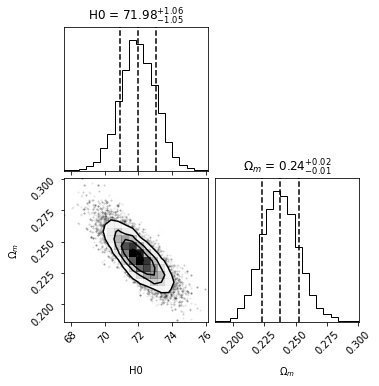

In [12]:
labels = ['H0','$\Omega_m$']
samples = sampler.flatchain
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])
chain = sampler.get_chain()
print("Chain shape is ",chain.shape)
print("number of samples =",len(samples))
H0_mean = np.mean(samples[:,0])
om_mean = np.mean(samples[:,1])
std_H0 = np.std(samples[:,0])
std_om = np.std(samples[:,1])
print("H0=",H0_mean)
print("Omega_m=",om_mean)
print("sigma_H0=",std_H0)
print("sigma_omega_m=",std_om)